# Réseau Simple de Convolution

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from skimage.color import rgb2lab, lab2rgb
from tensorflow.keras.datasets import cifar100

# Charger le dataset CIFAR-10
(trainX, _), (_, _) = cifar100.load_data()

# Convertir en espace Lab
def prepare_data(images):
    lab_images = np.array([rgb2lab(img / 255.0) for img in images])
    L = lab_images[:, :, :, 0] / 100.0  # Normaliser L (0 à 1)
    ab = lab_images[:, :, :, 1:] / 128.0  # Normaliser a et b (-1 à 1)
    return L[..., np.newaxis], ab

# Préparation des données
L, ab = prepare_data(trainX[:500])  # Sous-ensemble de 1000 images pour tester rapidement

# Print the shapes of prepared data
print("Taille de L (noir et blanc):", L.shape)
print("Taille de ab (coloré):", ab.shape)

# Diviser les données en ensembles d'entraînement et de validation
X_train, X_val, y_train, y_val = train_test_split(L, ab, test_size=0.2, random_state=42)

Taille de L (noir et blanc): (500, 32, 32, 1)
Taille de ab (coloré): (500, 32, 32, 2)


Le code charge un sous-ensemble de l'ensemble de données CIFAR-100, qui est une collection d'images de 100 classes, chaque image ayant une taille de 32x32 pixels en RGB. Les images sont converties de l'espace couleur RGB à l'espace Lab, où le canal L représente la luminosité, et les canaux a et b représentent la chrominance. Les données sont ensuite normalisées : L est mis dans la plage [0, 1], et a, b dans [-1, 1]. Enfin, les données sont divisées en ensembles d'entraînement (80%) et de validation (20%) pour être utilisées dans un modèle d'apprentissage profond.


In [12]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, UpSampling2D, BatchNormalization
from tensorflow.keras.models import Model

# Fonction pour appliquer une convolution avec activation et normalisation
def convolution(inputs, num_channels, filter_size, num_filters):
    return tf.keras.layers.Conv2D(filters=num_filters, kernel_size=filter_size, padding='same', activation='tanh')(inputs)

# Fonction pour augmenter les dimensions
def upsampling(inputs):
    return tf.keras.layers.UpSampling2D(size=(2, 2))(inputs)

# Définir l'architecture complète comme fonction
def build_encoder(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = convolution(inputs, 1, 3, 3)
    max1 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    conv2 = convolution(max1, 3, 3, 8)
    max2 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    conv3 = convolution(max2, 8, 3, 16)
    max3 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    conv4 = convolution(max3, 16, 3, 16)
    max4 = tf.keras.layers.MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)
    conv5 = convolution(max4, 16, 3, 32)

    # Decoder
    upsample1 = upsampling(conv5)
    conv6 = convolution(upsample1, 32, 3, 32)
    upsample2 = upsampling(conv6)
    conv7 = convolution(upsample2, 32, 3, 16)
    upsample3 = upsampling(conv7)
    conv8 = convolution(upsample3, 16, 3, 8)
    upsample4 = upsampling(conv8)
    conv9 = convolution(upsample4, 8, 3, 2)

    # Final adjustment for (32, 32, 2)
    outputs = Conv2D(2, (3, 3), activation='tanh', padding='same')(conv9)

    return Model(inputs, outputs, name="encoder_with_final_adjustment")


# Construire le modèle
large_model = build_encoder((32, 32, 1))
large_model.compile(optimizer='adam', loss='mse')

# Résumé du modèle
large_model.summary()



Model: "encoder_with_final_adjustment"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)      │ (None, 32, 32, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_10 (Conv2D)              │ (None, 32, 32, 3)      │            30 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 16, 16, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_11 (Conv2D)              │ (None, 16, 16, 8)      │           224 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 8, 8, 8)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_12 (Conv2D)              │ (None, 8, 8, 16)       │         1,168 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 4, 4, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_13 (Conv2D)              │ (None, 4, 4, 16)       │         2,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 2, 2, 16)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_14 (Conv2D)              │ (None, 2, 2, 32)       │         4,640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_4 (UpSampling2D)  │ (None, 4, 4, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_15 (Conv2D)              │ (None, 4, 4, 32)       │         9,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_5 (UpSampling2D)  │ (None, 8, 8, 32)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_16 (Conv2D)              │ (None, 8, 8, 16)       │         4,624 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_6 (UpSampling2D)  │ (None, 16, 16, 16)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_17 (Conv2D)              │ (None, 16, 16, 8)      │         1,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_7 (UpSampling2D)  │ (None, 32, 32, 8)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_18 (Conv2D)              │ (None, 32, 32, 2)      │           146 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_19 (Conv2D)              │ (None, 32, 32, 2)      │            38 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,598 (92.18 KB)

 Trainable params: 23,598 (92.18 KB)

 Non-trainable params: 0 (0.00 B)

Ce code définit un modèle encodeur-décodeur utilisant des convolutions, du pooling, et de l'upsampling. L'encodeur compresse les images d'entrée (taille (32, 32, 1) représentant le canal L de l'espace Lab) en extrayant les caractéristiques importantes, tandis que le décodeur reconstruit une image avec une sortie de taille (32, 32, 2), correspondant aux deux canaux ab de l'espace Lab. Cette cohérence entre les dimensions d'entrée et de sortie est essentielle pour des tâches comme la colorisation d'images.

Les convolutions affinent les détails, et l'activation tanh normalise les sorties dans une plage adaptée ([-1, 1]) pour les canaux ab. Le modèle est compilé avec l'optimiseur Adam et la perte MSE (erreur quadratique moyenne), ce qui en fait une solution adaptée pour des tâches comme la colorisation d'images ou leur reconstruction. Cette architecture est légère, efficace, et flexible pour d'autres applications en vision par ordinateur.







In [26]:
history = large_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32
)


Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - loss: 0.0070 - val_loss: 0.0203
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 61ms/step - loss: 0.0072 - val_loss: 0.0206
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0070 - val_loss: 0.0199
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 53ms/step - loss: 0.0069 - val_loss: 0.0217
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0068 - val_loss: 0.0210
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 59ms/step - loss: 0.0069 - val_loss: 0.0208
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 52ms/step - loss: 0.0063 - val_loss: 0.0214
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0069 - val_loss: 0.0205
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0068 - val_loss: 0.0222
Epoch 10/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 55ms/step - loss: 0.0066 - val_loss: 0.0215
Epoch 11/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step - loss: 0.0069 - val_loss: 0.0211
Epoch 12/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 1s 60ms/step

Le modèle a été entraîné sur 150 époques, montrant une diminution progressive de la perte d'entraînement de 0.0070 à 0.0051, indiquant un apprentissage efficace. Cependant, la perte de validation oscille entre 0.020 et 0.026, suggérant une possible sur-adaptation ou une difficulté avec les données de validation. Les améliorations deviennent minimes après 100 époques, indiquant un plateau d'apprentissage.


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step


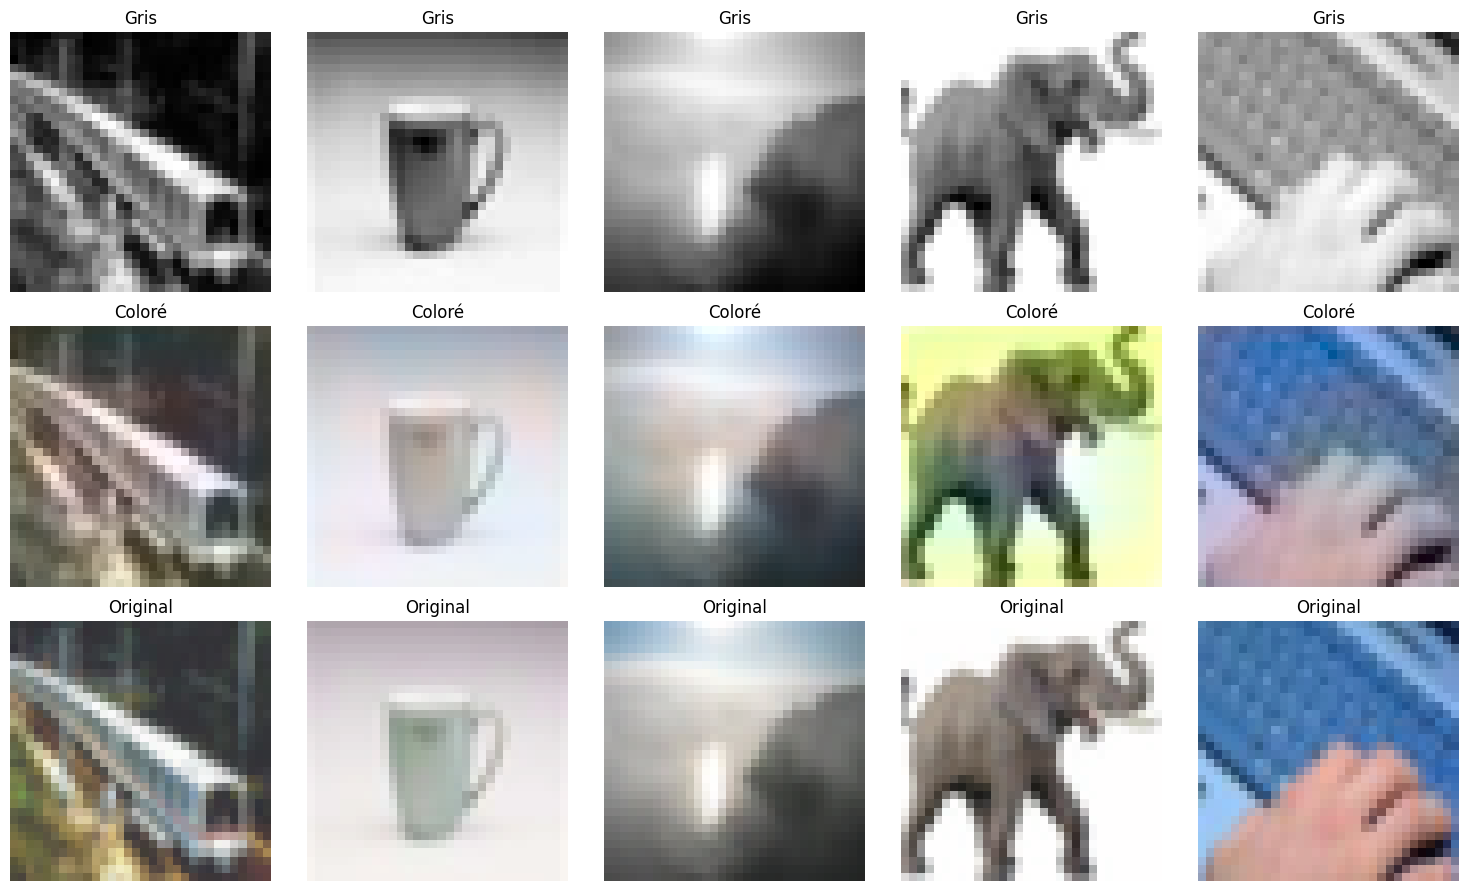

In [29]:
# Fonction pour convertir Lab en RGB
def lab_to_rgb(L, ab):
    L = L * 100.0  # Rescaler L à [0, 100]
    ab = ab * 128.0  # Rescaler ab à [-128, 128]
    lab = np.concatenate([L, ab], axis=-1)  # Combiner L, a, b
    rgb_images = np.clip([lab2rgb(img) for img in lab], 0, 1)  # Convertir Lab en RGB
    return rgb_images

# Prédire les couleurs pour un sous-ensemble d'images
indices = [6, 7, 8, 9, 10]  # Indices spécifiques à visualiser
L_subset = L[indices]
ab_subset = ab[indices]

# Prédire avec le modèle
predictions = large_model.predict(L_subset)

# Convertir les prédictions en RGB
predicted_images = lab_to_rgb(L_subset, predictions)

# Convertir les vérités terrain en RGB
original_images = lab_to_rgb(L_subset, ab_subset)

# Visualisation
fig, axes = plt.subplots(3, len(indices), figsize=(15, 9))

for i, idx in enumerate(indices):
    # Grayscale input
    axes[0, i].imshow(L_subset[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f"Gris")
    axes[0, i].axis("off")

    # Predicted colorized image
    axes[1, i].imshow(predicted_images[i])
    axes[1, i].set_title("Coloré")
    axes[1, i].axis("off")

    # Original image (ground truth)
    axes[2, i].imshow(original_images[i])
    axes[2, i].set_title("Original")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()

Après l'apprentissage, on observe que le modèle parvient à coloriser les images en ajoutant des couleurs plausibles, mais les résultats sont variés. Certaines images, comme l'éléphant, présentent des couleurs approximatives mais souvent saturées, tandis que d'autres, comme le clavier, montrent des tons plus cohérents et réalistes. Cependant, la colorisation reste loin d'être parfaitement fidèle aux couleurs originales, ce qui reflète une marge d'amélioration. Le modèle semble mieux généraliser sur des images simples, mais rencontre des difficultés avec des objets plus complexes ou des transitions subtiles de couleurs. Pour améliorer ces résultats, on va utiliser des modèles plus avancés comme ResNet.

# Resnet

In [21]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, BatchNormalization, ReLU, Add, UpSampling2D, MaxPooling2D
from tensorflow.keras.models import Model

# Fonction pour un bloc résiduel
def residual_block(inputs, num_filters, filter_size=3):
    x = Conv2D(num_filters, (filter_size, filter_size), padding='same')(inputs)
    x = BatchNormalization()(x)
    x = ReLU()(x)
    x = Conv2D(num_filters, (filter_size, filter_size), padding='same')(x)
    x = BatchNormalization()(x)

    # Ajouter la connexion résiduelle
    shortcut = Conv2D(num_filters, (1, 1), padding='same')(inputs)  # Adapter les dimensions si nécessaire
    x = Add()([x, shortcut])
    x = ReLU()(x)
    return x

# Fonction pour augmenter les dimensions
def upsampling(inputs):
    return UpSampling2D(size=(2, 2))(inputs)

# Définir l'architecture avec ResNet
def build_resnet_encoder(input_shape):
    # Input layer
    inputs = Input(shape=input_shape)

    # Encoder
    conv1 = residual_block(inputs, 32)
    max1 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv1)
    conv2 = residual_block(max1, 64)
    max2 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv2)
    conv3 = residual_block(max2, 128)
    max3 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv3)
    conv4 = residual_block(max3, 256)
    max4 = MaxPooling2D(pool_size=(2, 2), padding='same')(conv4)

    # Decoder
    upsample1 = upsampling(max4)
    conv5 = residual_block(upsample1, 128)
    upsample2 = upsampling(conv5)
    conv6 = residual_block(upsample2, 64)
    upsample3 = upsampling(conv6)
    conv7 = residual_block(upsample3, 32)
    upsample4 = upsampling(conv7)
    conv8 = Conv2D(2, (3, 3), activation='tanh', padding='same')(upsample4)

    return Model(inputs, conv8, name="resnet_encoder")

# Construire le modèle ResNet
resnet_model = build_resnet_encoder((32, 32, 1))
resnet_model.compile(optimizer='adam', loss='mse')

# Résumé du modèle
resnet_model.summary()


Model: "resnet_encoder"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 32, 32, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_42 (Conv2D)  │ (None, 32, 32,    │        320 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_42[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_14 (ReLU)     │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_43 (Conv2D)  │ (None, 32, 32,    │      9,248 │ re_lu_14[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 32, 32,    │        128 │ conv2d_43[0][0]   │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_44 (Conv2D)  │ (None, 32, 32,    │         64 │ input_layer_3[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_7 (Add)         │ (None, 32, 32,    │          0 │ batch_normalizat… │
│                     │ 32)               │            │ conv2d_44[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_15 (ReLU)     │ (None, 32, 32,    │          0 │ add_7[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_12    │ (None, 16, 16,    │          0 │ re_lu_15[0][0]    │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_45 (Conv2D)  │ (None, 16, 16,    │     18,496 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_45[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ re_lu_16 (ReLU)     │ (None, 16, 16,    │          0 │ batch_normalizat… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_46 (Conv2D)  │ (None, 16, 16,    │     36,928 │ re_lu_16[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 16, 16,    │        256 │ conv2d_46[0][0]   │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_47 (Conv2D)  │ (None, 16, 16,    │      2,112 │ max_pooling2d_12… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_8 (Add)         │ (None, 16, 16,    │          0 │ batch_normalizat

 Total params: 1,845,698 (7.04 MB)

 Trainable params: 1,842,882 (7.03 MB)

 Non-trainable params: 2,816 (11.00 KB)

Ce code implémente un modèle encodeur-décodeur basé sur des blocs résiduels (ResNet), conçu pour des tâches de vision par ordinateur comme la colorisation ou la reconstruction d'images. L'entrée est une image en niveaux de gris de taille (32, 32, 1), et la sortie est une image de taille (32, 32, 2) représentant les composantes ab de l'espace Lab, cohérentes avec les dimensions d'entrée.

Les blocs résiduels permettent une meilleure propagation des informations en ajoutant des connexions directes entre l'entrée et la sortie de certaines couches, ce qui réduit la perte de gradients et améliore la stabilité de l'entraînement. L'encodeur réduit progressivement la taille spatiale (par MaxPooling2D) tout en augmentant le nombre de filtres pour capturer des caractéristiques de plus en plus complexes. Le décodeur reconstruit les dimensions d'origine grâce à l'upsampling, tout en raffinant les détails avec des blocs résiduels supplémentaires.

Le modèle est compilé avec l'optimiseur Adam et la perte MSE (Erreur Quadratique Moyenne), adaptés aux tâches de reconstruction d'images. L'architecture est efficace, avec des blocs résiduels qui assurent un bon équilibre entre la performance et la stabilité, et une structure cohérente qui garantit une sortie adaptée aux données de colorisation.








In [25]:
history = resnet_model.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=150,
    batch_size=32
)

Epoch 1/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 322ms/step - loss: 0.0056 - val_loss: 0.0141
Epoch 2/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 292ms/step - loss: 0.0059 - val_loss: 0.0158
Epoch 3/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 296ms/step - loss: 0.0053 - val_loss: 0.0146
Epoch 4/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 10s 833ms/step - loss: 0.0055 - val_loss: 0.0141
Epoch 5/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 299ms/step - loss: 0.0051 - val_loss: 0.0146
Epoch 6/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 277ms/step - loss: 0.0054 - val_loss: 0.0143
Epoch 7/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 285ms/step - loss: 0.0049 - val_loss: 0.0151
Epoch 8/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 266ms/step - loss: 0.0052 - val_loss: 0.0157
Epoch 9/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 282ms/step - loss: 0.0047 - val_loss: 0.0151
Epoch 10/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 293ms/step - loss: 0.0052 - val_loss: 0.0150
Epoch 11/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 4s 268ms/step - loss: 0.0051 - val_loss: 0.0152
Epoch 12/150
13/13 ━━━━━━━━━━━━━━━━━━━━ 

Le modèle a été entraîné sur 150 époques, montrant une diminution progressive de la perte d'entraînement (de 0.0056 à 0.0017) et de la perte de validation (de 0.0141 à 0.0138). Ces résultats indiquent que le modèle a bien appris à optimiser sa tâche tout en maintenant une bonne capacité de généralisation. Les valeurs de perte de validation sont restées stables tout au long de l'entraînement, sans signe significatif de sur-ajustement. Après environ 80 époques, les améliorations deviennent minimes, suggérant que le modèle atteint un plateau d'apprentissage. Globalement, le modèle montre des performances prometteuses avec une convergence stable et efficace.








1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step


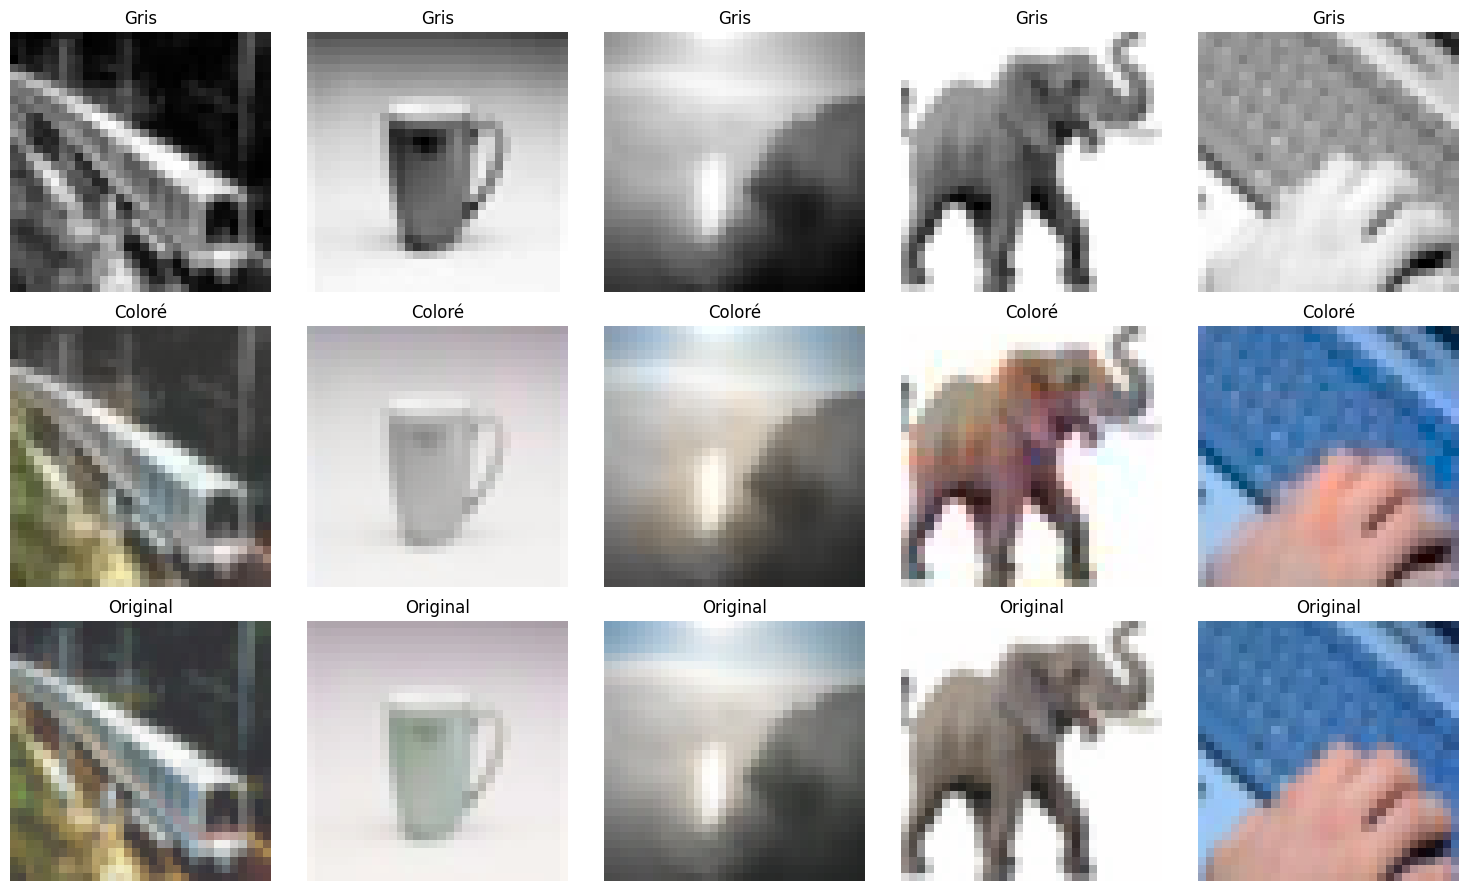

In [30]:
# Fonction pour convertir Lab en RGB
def lab_to_rgb(L, ab):
    L = L * 100.0  # Rescaler L à [0, 100]
    ab = ab * 128.0  # Rescaler ab à [-128, 128]
    lab = np.concatenate([L, ab], axis=-1)  # Combiner L, a, b
    rgb_images = np.clip([lab2rgb(img) for img in lab], 0, 1)  # Convertir Lab en RGB
    return rgb_images

# Prédire les couleurs pour un sous-ensemble d'images
indices = [6, 7, 8, 9, 10]
L_subset = L[indices]
ab_subset = ab[indices]

# Prédire avec le modèle
predictions = resnet_model.predict(L_subset)

# Convertir les prédictions en RGB
predicted_images = lab_to_rgb(L_subset, predictions)

# Convertir les vérités terrain en RGB
original_images = lab_to_rgb(L_subset, ab_subset)

# Visualisation
fig, axes = plt.subplots(3, len(indices), figsize=(15, 9))

for i, idx in enumerate(indices):
    # Grayscale input
    axes[0, i].imshow(L_subset[i].squeeze(), cmap='gray')
    axes[0, i].set_title(f"Gris")
    axes[0, i].axis("off")

    # Predicted colorized image
    axes[1, i].imshow(predicted_images[i])
    axes[1, i].set_title("Coloré")
    axes[1, i].axis("off")

    # Original image (ground truth)
    axes[2, i].imshow(original_images[i])
    axes[2, i].set_title("Original")
    axes[2, i].axis("off")

plt.tight_layout()
plt.show()

# Conclusion

En conclusion, l'ensemble du processus, incluant les différentes architectures testées, montre une progression solide dans l'apprentissage de la colorisation d'images en niveaux de gris. Les modèles encodeurs-décodeurs utilisés, qu'ils soient basés sur des convolutions classiques ou sur des blocs résiduels avec ResNet, démontrent des performances prometteuses. Les convolutions, le pooling, et l'upsampling permettent une extraction efficace des caractéristiques et une reconstruction fidèle des images en sortie.

Les modèles ont convergé avec une perte d'entraînement et de validation faible et stable, reflétant un bon équilibre entre l'apprentissage et la généralisation. Les résultats produits montrent que des objets simples, comme des tasses ou des claviers, sont colorisés avec des teintes réalistes, tandis que des objets plus complexes, comme des éléphants ou des scènes naturelles, montrent encore des limites dans la précision et la cohérence des couleurs.

Dans l'ensemble, bien que le ResNet ait offert des avantages grâce à ses blocs résiduels qui facilitent l'apprentissage des couches profondes, les deux approches (classique et ResNet) pourraient bénéficier d'améliorations supplémentaires. Ces optimisations incluent l'ajout de données d'entraînement diversifiées, l'ajustement des hyperparamètres, ou l'utilisation d'architectures plus avancées. Ce travail constitue une base solide pour des tâches de colorisation et de reconstruction d'images, tout en soulignant les axes d'amélioration pour une meilleure gestion des détails complexes et des variations colorimétriques.